In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import complex_ode, quad
from scipy.linalg import expm, logm
from scipy.optimize import minimize
from tqdm import trange
import math

## Pauli matrices 

In [2]:
Id =  np.array([[1., 0. ],[ 0.,1.]])
s_x = np.array([[0., 1. ],[ 1.,0.]])
s_y = np.array([[0.,-1.j],[1.j,0.]])
s_z = np.array([[1., 0. ],[0.,-1.]])

O = [Id,s_x,s_y,s_z]

up   = np.array([1,0],dtype=complex)
down = np.array([0,1],dtype=complex)

## Functions to calculate $[A,B]$, $\{A,B\}$ and $\frac{d}{dt} A$

In [3]:
harmonics = 3#10

sl = np.r_[-harmonics:harmonics+1]
sl2 = np.r_[-harmonics-1:harmonics]

def com(A,B):
    C = np.zeros((4,2*harmonics+1),dtype=complex)
    C[3,:] = 2j*( np.convolve(A[1,sl],B[2,sl],'same')
                 -np.convolve(A[2,sl],B[1,sl],'same'))[sl2]  
    
    C[1,:] = 2j*( np.convolve(A[2,sl],B[3,sl],'same')
                 -np.convolve(A[3,sl],B[2,sl],'same'))[sl2]
    
    C[2,:] = 2j*( np.convolve(A[3,sl],B[1,sl],'same')
                 -np.convolve(A[1,sl],B[3,sl],'same'))[sl2]
    return C

def anticom(A,B):
    C = np.zeros((4,2*harmonics+1),dtype=complex)
    for i in range(4):
        C[0,:]+= 2* np.convolve(A[i,sl],B[i,sl],'same')[sl2]
    for i in range(1,4):
        C[i,:] = 2*(np.convolve(A[0,sl],B[i,sl],'same')
                   +np.convolve(A[i,sl],B[0,sl],'same'))[sl2]
    return C

d_op = np.arange(2*harmonics+1)
d_op[-harmonics:] -= 2*harmonics+1
ddt = lambda X: -1j*omega*X @ np.diag(d_op)
norm = lambda X: np.trace(X @ X.T.conj())

## Define constants and the Hamiltonian

In [4]:
omega = np.sqrt(2)
T = 2*np.pi/omega
nu = 1/T
t = np.linspace(0,T,100)
#xi = np.linspace(0,2*np.pi  ,100) #dimensionless time

delta = 1
g = .5 #1

H = np.zeros((4,2*harmonics+1),dtype=complex)
### H = 1/2 delta*σz + g/2 (1+2cos(ωt))*σx
#H[3, 0] = delta/2 # σz
#H[1, 0] = g/2     # σx
#H[1, 1] = g/2     # e^iωtσx
#H[1,-1] = g/2     # e^-iωtσx

### H = delta*σz + g (1+2cos(ωt))*σx
#H[3, 0] = delta # σz
#H[1, 0] = g     # σx
#H[1, 1] = g     # e^iωtσx
#H[1,-1] = g     # e^-iωtσx

### H = 1/2 delta*s_z + g/2 (cos(omega*t)*s_x + sin(omega*t)*s_y)
H[3, 0] = delta/2
H[1, 1] =  g/4
H[1,-1] =  g/4
H[2, 1] =  g/4*1j
H[2,-1] = -g/4*1j

### H = delta*s_z + g (cos(omega*t)*s_x + sin(omega*t)*s_y)
#H[3, 0] = delta
#H[1, 1] =  g/2
#H[1,-1] =  g/2
#H[2, 1] =  g/2*1j
#H[2,-1] = -g/2*1j

## Derive the gauge potential and G

In [5]:
def A(X):
    #print(np.shape(X))
    N_iterations = 40
    C = np.zeros((4,2*harmonics+1,N_iterations),dtype=complex)
    C[:,:,0] = 1j   *ddt(X)
    for i in range(1,N_iterations):
        C[:,:,i] = 1j/(i+1) * com(X,C[:,:,i-1])

    return 1j*np.sum(C,axis=2)
    
def G(X):
    Am = A(X)
    return 1j*com(H,Am) - ddt(H) + ddt(Am)

## Transformations between the Fourier basis and the functional form of the operators

In [7]:
explicit = lambda X,t: np.einsum('jkl,j',np.einsum('ij,ikl',X,O),np.exp(-1j*omega*d_op*t))
explicit_matrix = lambda X: np.einsum('jkl,jm',np.einsum('ij,ikl',X,O),np.exp(-1j*omega*np.einsum('l,m',d_op,t)))
def explicitf(X):
    return lambda t: np.einsum('jkl,j',np.einsum('ij,ikl',X,O),np.exp(-1j*omega*d_op*t))

def fourier(f):

    X = np.zeros((4,2*harmonics+1),dtype=complex)
    #fun = lambda t:.5*np.einsum('k,i->ki',np.einsum('mn,knm',f(t),O),np.exp(1j*omega*d_op*t))
    #return nu*nquad(fun,[[0,T]])#,complex_func=True)[0]
    for i in trange(-harmonics,harmonics+1):
        for k in range(4):
            fki = lambda t: .5*np.trace(f(t)@O[k])*np.exp(1j*omega*i*t)
            X[k,i] = nu*(quad(fki,0,T, complex_func=True)[0])
            
    return X

fourierM = lambda M: .5*np.einsum('jk,ij->ki',np.einsum('mnj,knm',M,O),np.exp(1j*omega*np.einsum('i,j',d_op,t)))/100

def visualise_fourier_matrix(X):
    fig,ax = plt.subplots()
    ax.pcolormesh(np.arange(-harmonics-.5,harmonics+1,1),np.arange(-0.5,8,1),np.concatenate((X.real,X.imag),axis=0)[:,np.r_[-harmonics:harmonics+1]])

## Derivatives with respect to k

In [8]:
def elementary(m,l):
    E = np.zeros((4,2*harmonics+1),dtype=complex)
    E[m,l] = 1
    return E

def Delementary(m,l):
    E = np.zeros((4,2*harmonics+1),dtype=complex)
    E[m,l] = -1j*omega*l
    return E
    
def adj(X, k, Y):
    if k==0:
        return Y
    else:
        return com(X,adj(X,k-1,Y))

def dA(m,l, K):
    N_iterations = 40
    
    C = np.zeros((4,2*harmonics+1),dtype=complex)
    for n in range(N_iterations):
        for k in range(n):
            C +=(1j**n/math.factorial(n+1)) * (adj(K,k,com(elementary(m,l),adj(K,n-1-k,ddt(K)))) )
        C += -(1j**n/math.factorial(n+1))*1j*omega*l*adj(K,n,elementary(m,l))
    return -C

def dA_memory(m,l,K):
    N_iterations = 40
    memory_part = np.zeros((4,2*harmonics+1,N_iterations),dtype=complex) # i-th element stores adj(K,i,ddt(K))
    memory_elem = np.zeros((4,2*harmonics+1,N_iterations),dtype=complex) # i-th element stores adj(K,i,elementary(m,,l))
    memory = np.zeros((4,2*harmonics+1,N_iterations,N_iterations),dtype=complex)
    memory_part[:,:,0] = ddt(K)
    memory_elem[:,:,0] = elementary(m,l)
    for i in range(1,N_iterations):
        memory_part[:,:,i] = com(K,memory_part[:,:,i-1]) # i=3: KKKD
        memory_elem[:,:,i] = com(K,memory_elem[:,:,i-1]) # i=3: KKKE
    for n in range(1,N_iterations):
        memory[:,:,0,n] = com(elementary(m,l),memory_part[:,:,n-1]) # (k,n) = (0,4): EKKKD
        for k in range(1,n):
            memory[:,:,k,n] = com(K,memory[:,:,k-1,n-1]) # (k,n) = (2,6): KKEKKKD
    
    C = np.zeros((4,2*harmonics+1),dtype=complex)
    for n in range(N_iterations):
        C += (1j**n/math.factorial(n+1)) * (np.sum(memory[:,:,:,n],axis=2) - 1j*omega*l*memory_elem[:,:,n])
        #for k in range(n):
        #    C +=(1j**n/math.factorial(n+1)) * (adj(K,k,com(elementary(m,l),memory_part[:,:,n-1-k])))
        #C += -(1j**n/math.factorial(n+1))*1j*omega*l*adj(K,n,elementary(m,l))
    return -C

def dtA(K): ## returns the same as derivative(A(K)) but is slower
    N_iterations = 20#40
    C = np.zeros((4,2*harmonics+1),dtype=complex)
    for n in range(N_iterations):
        for k in range(n-1):
            C += (1j**n/math.factorial(n+1))* (adj(K,k, com(ddt(K),adj(K,n-1-k,ddt(K)))))
        C += (1j**n/math.factorial(n+1))*adj(K,n,ddt(ddt(K)))
    return -C

In [9]:
def dS(K):
    #print(np.shape(K))
    C = np.zeros((4,2*harmonics+1),dtype=complex)
    G0 = G(K)
    for n in range(4):
        for l in range(-harmonics,harmonics+1):
            DA = dA_memory(n,l,K)
            dG = 1j*com(H,DA) + ddt(DA)
            C[n,l] = np.sum(dG*G0.conj())
    return C

## Functions to calculate time-ordered exponentials

In [10]:
def evolution(H):
    return lambda t, psi: -1j*np.dot(H(t), psi)

def Texp(H,t0,t1):
    solver = complex_ode(evolution(H))
    solver.set_integrator('dop853',rtol=1e-9,atol=1e-12)
    solver.set_initial_value(up,t0)
    U = np.zeros((2,2),dtype=complex)
    solver.integrate(t1)
    U[:,0] = solver.y
    solver.set_initial_value(down,t0)
    solver.integrate(t1)
    U[:,1] = solver.y
    return U

## Construct random ansatz

In [11]:
rng = np.random.default_rng(0)
def random_matrix():
    X = np.zeros((4,2*harmonics+1),dtype=complex)
    X[:,1:11] = (rng.random((4,10))+1j*rng.random((4,10))) @ np.diag(np.exp(-3*np.arange(10)))
    X[:,0] = rng.random(4)
    X[:,-10:] = np.flip(X[:,1:11], axis=1).conj()
    return X

## Iterate to find the optimal kick operator

#### Manually

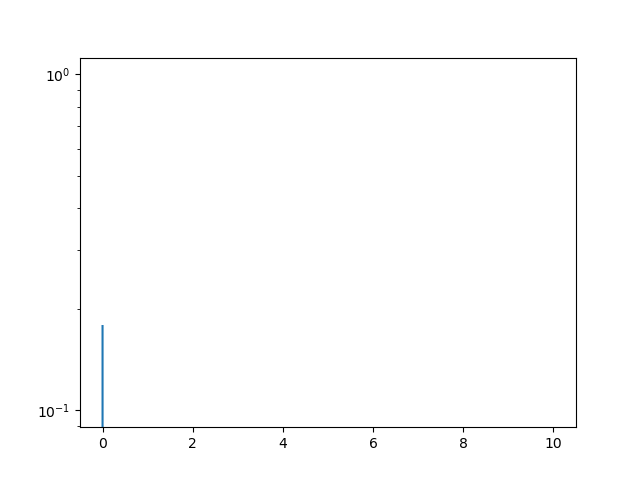

In [19]:
eta = 1e-2
N_epochs = 11#00
K = H.copy()
#K = random_matrix()

y = np.zeros((N_epochs))#,dtype=com)
eta_history = np.zeros((400))

fig, ax = plt.subplots()

y[0] = norm(G(K)).real
#y[0] = np.sum(G(K)**2).real
ax.plot(np.arange(N_epochs),y)

ax.set_yscale('log')
plt.show()

In [20]:
new_direction = True
for i in range(N_epochs):
    
    if new_direction:
        step = dS(K).conj()
    
    S_0 = norm(G(K)).real
    S_1 = norm(G(K-eta*step)).real
    S_2 = norm(G(K-2*eta*step)).real
    modified_eta = eta*(1+.5*(S_2-S_0)/(2*S_1-S_2-S_0))
    if S_1 > S_0: # if taking 1 step does not lead to lower cost, the step is too large
        #print("D<0.",eta,modified_eta)
        eta/=2
        new_direction = False
    elif modified_eta < 0: # if the second derivative is negative, take 1 step, but next time try with a bigger step for faster convergence 
        K -= eta*step
        #print("D2<0. step eta",eta,modified_eta)
        eta*=2
        new_direction = True
    elif 0.5 < modified_eta/eta and modified_eta/eta < 2: # move according to the second-derivative-implied minimum
        #print("good eta",eta,modified_eta)
        #K -= modified_eta*step
        K -= (modified_eta+eta)/2*step
        #eta = (modified_eta+eta)/2
        eta = modified_eta
        new_direction = True
    elif modified_eta < eta: # approximate the second derivative better with a smaller step
        #print("eta>>modified_eta",eta,modified_eta)
        eta /= 2
        new_direction = False
    elif modified_eta > eta: # approximate the second derivative better with a larger step
        #print("eta<<modified_eta",eta,modified_eta)
        eta *= 2
        new_direction = False
    
    
    #step = G(K)
    #K -= eta*step#.conj()
    """
    if i<14:
        K -= 3e-2*step
    elif i<20:
        K -= 5e-3*step
    if True:#else:#if True:
        S_0 = norm(G(K)).real
        S_1 = norm(G(K-eta*step)).real
        S_2 = norm(G(K-2*eta*step)).real
        modified_eta = eta*(1+.5*(S_2-S_0)/(2*S_1-S_2-S_0))
        print(modified_eta)
        K -= max(0.5*modified_eta,eta/10)*step#, 0,1e3))*step
    """
    #y[i] = np.sum(G(K)**2).real
    #print(.5*(S_2-S_0)/(2*S_1-S_2-S_0))
    y[i] = norm(G(K)).real
    #print(y[i])
    #if i > 1:
    #    if y[i] < y[i-1]:# and eta < 1e-2:
    #        eta*=1.01
    #    else:
    #        #break
    #        eta/=2#1.001
    ax.lines[0].set_ydata(y)
    ax.set_ylim(min(y[:(i+1)]),max(y))
    fig.canvas.draw()
    #print(norm(step - step[:,np.r_[0:-2*harmonics-1:-1]].conj()))


/tmp/ipykernel_7123/482993890.py:63: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(min(y[:(i+1)]),max(y))


good eta 2.56 2.659895843100906
good eta 2.659895843100906 1.3394778747092697
good eta 1.3394778747092697 1.337295803945765


## Calculate the corresponding gauge potential and Floquet Hamiltonian

In [21]:
K_t = explicit_matrix(K)
A_t = explicit_matrix(A(K))
H_t = explicit_matrix(H)

P_t = np.zeros((2,2,100),dtype=complex)
for i in range(100):
    P_t[:,:,i] = expm(1j*K_t[:,:,i])

HF_t = H_t - A_t

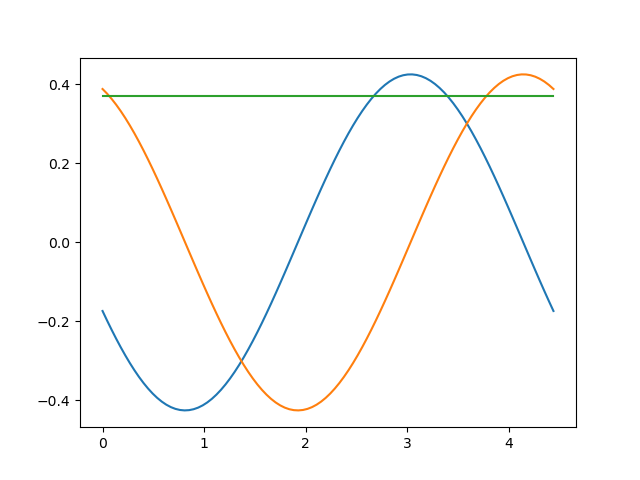

In [22]:
plt.close('all')
plt.plot(t,np.imag(.5*np.einsum('ijk,ji',P_t,s_x)))
plt.plot(t,np.imag(.5*np.einsum('ijk,ji',P_t,s_y)))
plt.plot(t,np.imag(.5*np.einsum('ijk,ji',P_t,s_z)))
plt.show()

## Compare the Floquet Hamiltonian obtained with the variational principle to the time-ordered exponential

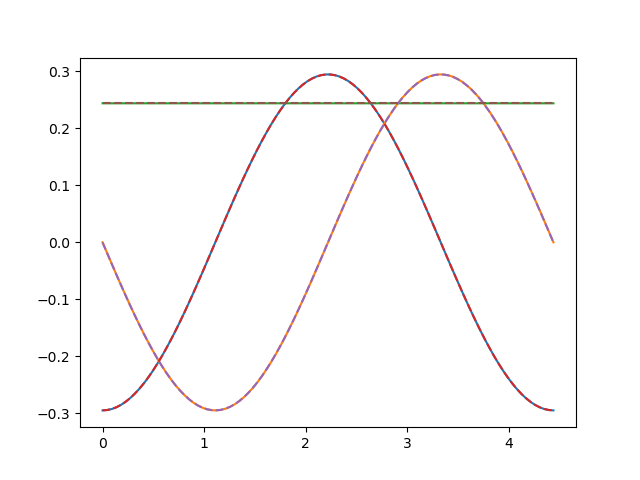

In [23]:
U_F_t = np.zeros((2,2,100),dtype=complex)
H_FT_t = np.zeros((2,2,100),dtype=complex)


for i in range(100):
    U_F_t[:,:,i] = Texp(explicitf(H),t[i],T+t[i])
    H_FT_t[:,:,i] = logm(U_F_t[:,:,i])/(-1j*T)

plt.close('all')
plt.plot(t,np.real(.5*np.einsum('ijk,ji',HF_t,s_x)))
plt.plot(t,np.real(.5*np.einsum('ijk,ji',HF_t,s_y)))
plt.plot(t,np.real(.5*np.einsum('ijk,ji',HF_t,s_z)))
#plt.plot(t,np.real(.5*np.einsum('ijk,ji',HF_t,Id)))
plt.plot(t,np.real(.5*np.einsum('ijk,ji',H_FT_t,s_x)),linestyle='dashed')
plt.plot(t,np.real(.5*np.einsum('ijk,ji',H_FT_t,s_y)),linestyle='dashed')
plt.plot(t,np.real(.5*np.einsum('ijk,ji',H_FT_t,s_z)),linestyle='dashed')
#plt.plot(t,np.real(.5*np.einsum('ijk,ji',H_FT_t,Id)),linestyle='dashed')
plt.show()

## Compare the gauge potentials

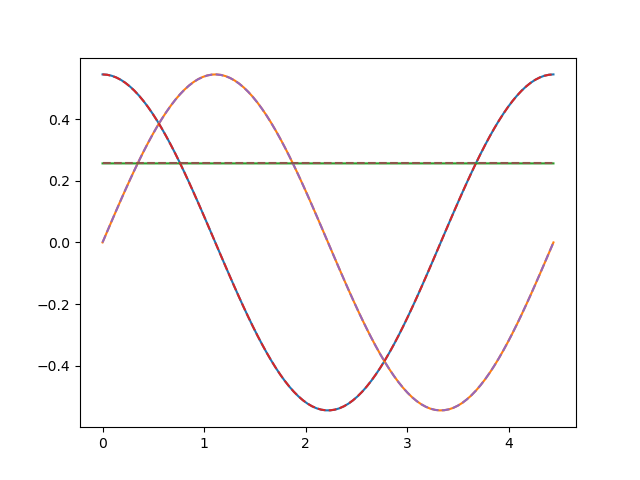

In [24]:
A_T_t = H_t - H_FT_t

plt.close('all')
#plt.plot(t,np.real(.5*np.trace(A_t, axis1=0, axis2=1)))
plt.plot(t,np.real(.5*np.einsum('ijk,ji',A_t,s_x)))
plt.plot(t,np.real(.5*np.einsum('ijk,ji',A_t,s_y)))
plt.plot(t,np.real(.5*np.einsum('ijk,ji',A_t,s_z)))
plt.plot(t,np.real(.5*np.einsum('ijk,ji',A_T_t,s_x)),linestyle='dashed')
plt.plot(t,np.real(.5*np.einsum('ijk,ji',A_T_t,s_y)),linestyle='dashed')
plt.plot(t,np.real(.5*np.einsum('ijk,ji',A_T_t,s_z)),linestyle='dashed')
plt.show()

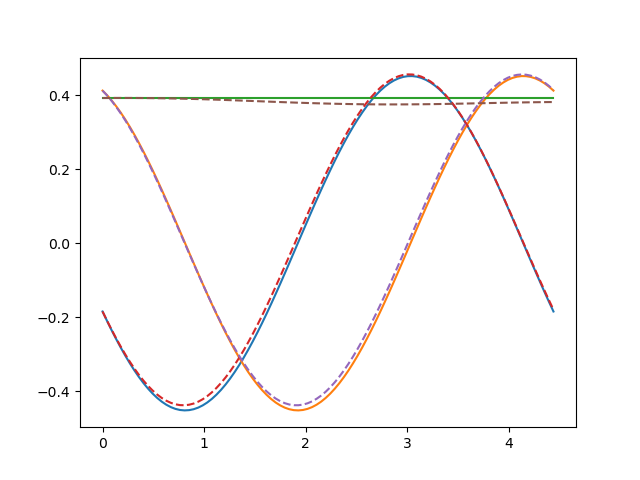

In [25]:
P_T_t = np.zeros((2,2,100),dtype=complex)
K_T_t = np.zeros((2,2,100),dtype=complex)


dt = T/100
#P_T_t[:,:,0] = Id #Floquet-Magnus
P_T_t[:,:,0] = P_t[:,:,0] # van Vleck 
for i in range(1,100):
    P_T_t[:,:,i] = expm(-1j*dt*A_T_t[:,:,i]) @ P_T_t[:,:,i-1]

for i in range(100):
    K_T_t[:,:,i] = -1j*logm(P_T_t[:,:,i])

plt.close('all')
plt.plot(t,np.real(.5*np.einsum('ijk,ji',K_t,s_x)))
plt.plot(t,np.real(.5*np.einsum('ijk,ji',K_t,s_y)))
plt.plot(t,np.real(.5*np.einsum('ijk,ji',K_t,s_z)))
plt.plot(t,np.real(.5*np.einsum('ijk,ji',K_T_t,s_x)),linestyle='dashed')
plt.plot(t,np.real(.5*np.einsum('ijk,ji',K_T_t,s_y)),linestyle='dashed')
plt.plot(t,np.real(.5*np.einsum('ijk,ji',K_T_t,s_z)),linestyle='dashed')
plt.show()

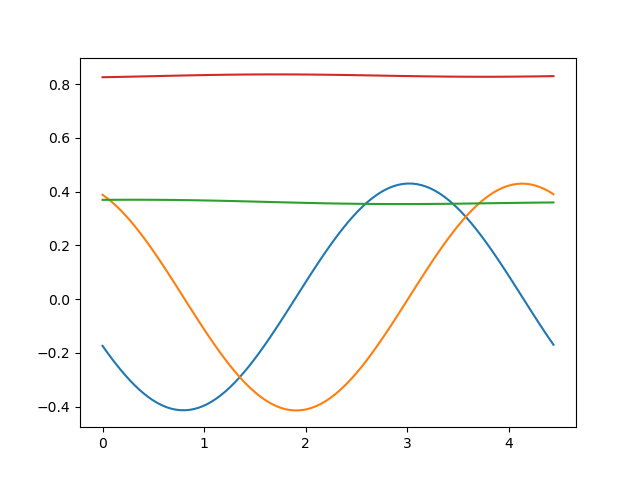

In [26]:
plt.close('all')
plt.plot(t,np.imag(.5*np.einsum('ijk,ji',P_T_t,s_x)))
plt.plot(t,np.imag(.5*np.einsum('ijk,ji',P_T_t,s_y)))
plt.plot(t,np.imag(.5*np.einsum('ijk,ji',P_T_t,s_z)))
plt.plot(t,np.real(.5*np.einsum('ijk,ji',P_T_t,Id)))
plt.show()